
## PARTE 0: CONFIGURAÇÃO DO AMBIENTE
 

In [48]:
# 1. Instalação de bibliotecas usando o comando mágico %pip
# Garante que a instalação ocorra no kernel correto do notebook.
%pip install -q pandas numpy pyarrow fastparquet matplotlib seaborn

# 2. Importação das bibliotecas
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Configuração de visualização do Pandas
# Garante que todas as colunas de um DataFrame sejam exibidas
pd.set_option('display.max_columns', None)

# Configura o estilo dos gráficos para um visual mais agradável
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

print("Ambiente configurado e bibliotecas importadas com sucesso!")
print(f"Versão do Pandas: {pd.__version__}")

Note: you may need to restart the kernel to use updated packages.
Ambiente configurado e bibliotecas importadas com sucesso!
Versão do Pandas: 2.3.3



## PARTE 1: CARGA E ESTRUTURAÇÃO DO SINASC


In [49]:
# --- 1.1 Carregando os dados do SINASC (Nascidos Vivos) ---
print("Iniciando a carga dos dados do SINASC...")

# ETAPA 1: Encontrar todos os caminhos dos arquivos .parquet
# O padrão 'sinasc_2020_2022/**/*.parquet' busca recursivamente em todas as subpastas.
parquet_path = 'sinasc_2020_2022/**/*.parquet'
list_parqutet_files = glob.glob(parquet_path, recursive=True)
print(f"Encontrados {len(list_parqutet_files)} arquivos Parquet.")
# Vamos exibir os 3 primeiros caminhos para verificar se estão corretos.
print("Exemplo de caminhos encontrados:")
print(list_parqutet_files[:3])

# ETAPA 2: Iterar, ler cada arquivo, extrair metadados e armazenar em uma lista
list_dfs = []

for file_path in list_parqutet_files:
    temp_df = pd.read_parquet(file_path)   # Lê o arquivo Parquet em um DataFrame temporário
    path_parts = file_path.split(os.sep) # Divide o caminho em partes
    dir_name = path_parts[-2]  # Nome do diretório (ano)
    year_collect = int(dir_name[-4:]) # Extrai o ano dos últimos 4 caracteres
    uf_collect = dir_name[2:4]   # Extrai a UF dos caracteres na posição 2 e 3

    temp_df['ANO_COLETA'] = year_collect  # Adiciona a coluna do ano de coleta
    temp_df['UF_COLETA'] = uf_collect    # Adiciona a coluna da UF de coleta

    list_dfs.append(temp_df)  # Adiciona o DataFrame temporário à lista

# ETAPA 3: Concatenar todos os DataFrames em um único DataFrame
if list_dfs:
    df_sinasc = pd.concat(list_dfs, ignore_index=True)
    print("\nDados do SINASC carregados e consolidados com sucesso!")
    print(f"Total de registros no DataFrame final: {len(df_sinasc)}")
    print(f"Total de colunas: {len(df_sinasc.columns)}")

    display(df_sinasc.head())
else:
    print("\nErro: Nenhum DataFrame foi carregado. Verifique os arquivos Parquet.")

Iniciando a carga dos dados do SINASC...
Encontrados 984 arquivos Parquet.
Exemplo de caminhos encontrados:
['sinasc_2020_2022/DNSP2022/part-00001-bd6c59fe-baea-40ee-a750-b5ab8e63d89a-c000.gz.parquet', 'sinasc_2020_2022/DNSP2022/part-00003-bd6c59fe-baea-40ee-a750-b5ab8e63d89a-c000.gz.parquet', 'sinasc_2020_2022/DNSP2022/part-00010-bd6c59fe-baea-40ee-a750-b5ab8e63d89a-c000.gz.parquet']

Dados do SINASC carregados e consolidados com sucesso!
Total de registros no DataFrame final: 3999785
Total de colunas: 21


,CODMUNNASC,LOCNASC,CODMUNRES,DTNASC,SEXO,RACACOR,PESO,IDADEMAE,ESTCIVMAE,ESCMAE,GRAVIDEZ,CONSULTAS,RACACORMAE,DTNASCMAE,GESTACAO,SEMAGESTAC,CONSPRENAT,PARTO,CODESTAB,ANO_COLETA,UF_COLETA
0,355240,1,355240,30032022,2,4,2600,33,1,4,1,3,4,19021989,4,36,05,2,2083981,2022,SP
1,355030,1,355030,29062022,2,4,3800,36,2,3,1,4,4,03061986,5,41,16,1,7711980,2022,SP
2,355710,1,355710,21062022,2,1,3035,36,2,4,1,4,1,22021986,5,38,10,2,2081377,2022,SP
3,355210,1,355210,29042022,2,1,3420,34,1,5,1,2,1,18041988,5,38,03,2,2079704,2022,SP
4,355370,1,355370,27062022,1,4,2880,22,1,4,1,4,4,02101999,5,38,11,2,2078295,2022,SP


## ESTRATÉGIA DE OTIMIZAÇÃO: REDUÇÃO DO USO DE MEMÓRIA

In [50]:
# Função para reduzir o uso de memória dos DataFrames.

def optimize_memory_usage(df, print_log=True):
    """
    Itera sobre todas as colunas de um DataFrame e modifica o tipo de dado
    para o formato mais eficiente em memória.

    Args:
    df (pd.DataFrame): O DataFrame a ser otimizado.
    print_log (bool): Se True, imprime o log da redução de memória.

    Returns:
    pd.DataFrame: O DataFrame otimizado.
    """
    if print_log:
        # Calcula o uso de memória inicial
        mem_usage_before = df.memory_usage(deep=True).sum() / 1024**2
        print(f"Uso de memória inicial: {mem_usage_before:.2f} MB")
    
    for col in df.columns:
        col_type = df[col].dtype

        # Verifica se a coluna é numérica (inteiro ou float)
        if pd.api.types.is_numeric_dtype(col_type) and not pd.api.types.is_datetime64_any_dtype(df[col]):
            c_min = df[col].min()
            c_max = df[col].max()
            
            # Se for do tipo inteiro, tenta diminuir para o menor inteiro possível
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            # Se for do tipo float, tenta diminuir para um float menor
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        
        # Se a coluna for de texto (object)
        elif col_type == 'object':
            # Se a proporção de valores únicos for baixa, converte para 'category'
            # O tipo 'category' é muito mais eficiente para strings repetidas (ex: 'UF_COLETA')
            if df[col].nunique() / len(df[col]) < 0.5:
                df[col] = df[col].astype('category')
    
    if print_log:
        # Calcula o uso de memória final
        mem_usage_after = df.memory_usage(deep=True).sum() / 1024**2
        reduction = 100 * (mem_usage_before - mem_usage_after) / mem_usage_before
        print(f"Uso de memória final: {mem_usage_after:.2f} MB ({reduction:.2f}% de redução)")
        
    return df

print("Função 'optimize_memory_usage' definida com sucesso.")

Função 'optimize_memory_usage' definida com sucesso.


In [51]:
# Aplicando a otimização no df_sinasc

print("Otimizando df_sinasc...")
# Chamamos a função e sobrescrevemos a variável original com a versão otimizada
df_sinasc = optimize_memory_usage(df_sinasc)

# Faremos o mesmo para o df_ibge_cities quando o carregarmos.
# Por enquanto, garantimos que o df_sinasc está leve.

Otimizando df_sinasc...
Uso de memória inicial: 4605.44 MB
Uso de memória final: 199.19 MB (95.67% de redução)



## PARTE 1.2: CARREGANDO DADOS DO IBGE E ENRIQUECENDO O DF_SINASC

In [52]:
# --- 1.2.1 Carregando e Otimizando os dados do IBGE (.map() strategy)

print("Carregando e otimizando a base de cidades e estados do IBGE")
url_ibge_cities = 'https://raw.githubusercontent.com/leogermani/estados-e-municipios-ibge/master/municipios.csv'
df_ibge_cities = pd.read_csv(url_ibge_cities)
df_ibge_cities.rename(columns={
    'COD UF': 'COD_UF', 
    'COD': 'COD_MUN', 
    'NOME': 'NOME_MUN'
}, inplace=True)
df_ibge_cities = optimize_memory_usage(df_ibge_cities, print_log=False)
url_ibge_states = 'https://raw.githubusercontent.com/leogermani/estados-e-municipios-ibge/master/estados.csv'
df_ibge_states = pd.read_csv(url_ibge_states)
df_ibge_states.rename(columns={
    'COD': 'COD_UF', 
    'NOME': 'NOME_UF', 
    'SIGLA': 'SIGLA_UF'
}, inplace=True)

# --- 1.2.2 Preparando os "Dicionários de Tradução"

print("\nCriando dicionários de tradução para cidades e estados")
map_uf_code_to_name = pd.Series(df_ibge_states.NOME_UF.values, index=df_ibge_states.COD_UF).to_dict()
map_uf_code_to_sigla = pd.Series(df_ibge_states.SIGLA_UF.values, index=df_ibge_states.COD_UF).to_dict()
index_mun_6_digits = df_ibge_cities['COD_MUN'].astype(str).str[:6].astype(int) # capture apenas os 6 primeiros dígitos de COD_MUN
map_mun_code_to_name = pd.Series(df_ibge_cities.NOME_MUN.values, index=index_mun_6_digits).to_dict()
print("Dicionários criados.")

# --- 1.2.3 Preparando o df_sinasc e Aplicando o .map()
print("\nLimpando chaves do df_sinasc e aplicando .map() para enriquecer os dados")
codmunnasc_cleaned_str = df_sinasc['CODMUNNASC'].astype(str).str.extract('(\\d+)')[0].fillna('0') # Extrai apenas os dígitos
codmunnasc_limpo_int = pd.to_numeric( codmunnasc_cleaned_str, errors='coerce').astype('Int64') # Converte para Int64, permitindo NaN
cod_uf_nasc = pd.to_numeric(codmunnasc_cleaned_str.str[:2], errors='coerce').astype('Int64') # Extrai os 2 primeiros dígitos para COD_UF

#Aplicando o mapeamento.
df_sinasc['COD_UF_NASC'] = cod_uf_nasc
df_sinasc['NOME_UF_NASC'] = df_sinasc['COD_UF_NASC'].map(map_uf_code_to_name)
df_sinasc['SIGLA_UF_NASC'] = df_sinasc['COD_UF_NASC'].map(map_uf_code_to_sigla)
df_sinasc['NOME_MUNIC_NASC'] = codmunnasc_limpo_int.map(map_mun_code_to_name)
#Atualizando a coluna CODMUNNASC com a versão limpa
df_sinasc['CODMUNNASC'] = codmunnasc_limpo_int

df_sinasc_enriched = df_sinasc
print("Enriquecimento e limpeza da CODMUNNASC concluído.")
display(df_sinasc_enriched.sample(10))

#liberando memória
del df_ibge_cities
del df_ibge_states
import gc
gc.collect()
print("\nDataFrames auxiliares liberados da memória")

Carregando e otimizando a base de cidades e estados do IBGE

Criando dicionários de tradução para cidades e estados
Dicionários criados.

Limpando chaves do df_sinasc e aplicando .map() para enriquecer os dados
Enriquecimento e limpeza da CODMUNNASC concluído.


,CODMUNNASC,LOCNASC,CODMUNRES,DTNASC,SEXO,RACACOR,PESO,IDADEMAE,ESTCIVMAE,ESCMAE,GRAVIDEZ,CONSULTAS,RACACORMAE,DTNASCMAE,GESTACAO,SEMAGESTAC,CONSPRENAT,PARTO,CODESTAB,ANO_COLETA,UF_COLETA,COD_UF_NASC,NOME_UF_NASC,SIGLA_UF_NASC,NOME_MUNIC_NASC
1198416,330170,1,330510,14102020,2,4,3655,37,5,4,1,4,4,27051983,5,39,07,2,7244339,2020,RJ,33,Rio de Janeiro,RJ,Duque de Caxias
273282,220390,1,220390,03042022,1,4,3436,30,2,4,1,3,4,18041991,5,40,06,2,2365146,2022,PI,22,Piauí,PI,Floriano
3684352,260890,1,260950,29092022,2,4,3690,29,2,4,1,4,4,12101992,5,39,08,2,7551584,2022,PE,26,Pernambuco,PE,Limoeiro
105502,351880,1,351880,06112022,1,4,2600,25,1,4,1,4,4,31071997,4,35,08,1,2040069,2022,SP,35,São Paulo,SP,Guarulhos
1304206,250750,1,250180,20112020,2,4,2580,25,2,4,1,3,4,24061995,4,36,06,2,2399644,2020,PB,25,Paraíba,PB,João Pessoa
3391374,150565,1,150565,24012022,1,4,2900,23,5,4,1 *,3,4,20021998,5,37,06,2,3654796,2022,PA,15,Pará,PA,Placas
1942850,261160,1,260860,06092020,2,4,3235,26,1,4,1,4,4,29031994,5,39,11,1,0000396,2020,PE,26,Pernambuco,PE,Recife
2128404,355030,1,355030,05022021,2,4,3930,22,1,4,1,4,4,01021999,5,40,09,1,2077620,2021,SP,35,São Paulo,SP,São Paulo
3491738,160030,1,160030,24122021,1,2,2924,33,1,4,1,4,2,23081988,5,37,07,1,2020068,2021,AP,16,Amapá,AP,Macapá
3892643,314390,1,314390,09032021,1,4,4020,21,1,4,1,4,4,03041999,5,40,09,2,4042085,2021,MG,31,Minas Gerais,MG,Muriaé



DataFrames auxiliares liberados da memória


## DIAGNÓSTICO: Análise das colunas DTNASC e DTNASCMAE antes da limpeza.


In [53]:
print("--- INICIANDO DIAGNÓSTICO DAS COLUNAS DE DATA ---")

df_diag = df_sinasc_enriched.copy()

# 1 - VALIDAÇÃO DO ANO DE COLETA
print("\n--- Validando o Ano de Coleta ---")
valid_years = [2020, 2021, 2022]
find_years = df_diag['ANO_COLETA'].unique()
invalid_years = [year for year in find_years if year not in valid_years]

if invalid_years:
    print(f"ALERTA: A coluna 'ANO_COLETA' contém anos inválidos: {invalid_years}")
    # Definimos nosso teto de realidade manualmente
    ceiling_year = 2022
else:
    print(f"OK: Todos os anos de coleta encontrados ({list(find_years)}) são válidos.")
    # Usamos o máximo dos dados, pois confiamos neles
    ceiling_year = df_diag['ANO_COLETA'].max()
    
print(f"==> Usando {ceiling_year} como o ano máximo de referência para a análise.")

date_cols_to_diagnose = ['DTNASC', 'DTNASCMAE']

for col in date_cols_to_diagnose:
    print(f"\n\n---Análise da coluna: {col}---")
    # 2 - Analise de tipos e nulos
    print(f"Tipo de dado original: { df_diag[col].dtype}")
    null_count = df_diag[col].isnull().sum()
    print(f"Valores nulos (originais): { null_count} ({ null_count / len(df_diag):.2%})") # Exibe a contagem e a porcentagem de valores nulos

    # 3 - Analise do formato (após converter para string)
    print("\nAnálise de formato (Tamanho esperado da string 8 'DDMMAAAA')")
    series_str = df_diag[col].astype(str)
    length_counts = series_str.str.len().value_counts().sort_index()
    print(f"Contagem de tamanhos de string: { length_counts}")
    
    # Verificando conteúdo não-numérico
    no_digit = series_str[~series_str.str.isdigit().fillna(False)] # Filtra valores que não são dígitos
    if not no_digit.empty:
        print(f"\nEncontrados {len(no_digit)} valores não numericos (estão 'sujos').")
        print("Exemplos de valores não numéricos")
        display(no_digit.value_counts().head())
    else:
        print("\n Todos os valores (não nulos) são digitos. (estão 'limpos').")

    # 4 - Tentativa de conversão e análise de erros
    series_dt = pd.to_datetime( series_str, format='%d%m%Y', errors='coerce') # Converte para datetime, valores inválidos viram NaT
    count_convert_fails = series_dt.isnull().sum() # Conta quantos valores falharam na conversão
    print(f"\n Após conversão para data (ddmmyyyy):")
    print(f"Total falhas na conversão (NaT): { count_convert_fails } ({ count_convert_fails / len(df_diag):.2%})") #

    # 5 - Análise de intervalos (datas convertidas e plausíveis)
    
    valid_dates = series_dt.dropna()
    if not valid_dates.empty:
        print(f"\n Análise de intervalos das datas válidas:")
        print(f"Data mínima: { valid_dates.min().date() }")
        print(f"Data máxima: { valid_dates.max().date() }")

        #verificando datas futuras (dentro do contexto do DataFrame 2020-2022)
        future_dates = valid_dates[valid_dates.dt.year > ceiling_year]

        if not future_dates.empty:
            print(f"\n ALERTA: Encontradas { len(future_dates) } datas posteriores ao último ano válido de coleta ({ceiling_year})!")
            print("Exemplos de datas futuras:")
            print(future_dates.value_counts().head())
        
        #verificando datas muito antigas (dentro do contexto do DataFrame 2020-2022)
        old_dates = valid_dates[valid_dates.dt.year < 1920]
        if not old_dates.empty:
            print(f"\n ALERTA: Encontradas { len(old_dates) } datas anteriores a 1920!")
            print("Exemplos de datas muito antigas:")
            print(old_dates.value_counts().head())
            
print("\n--- FIM DO DIAGNÓSTICO DAS COLUNAS DE DATA ---")

--- INICIANDO DIAGNÓSTICO DAS COLUNAS DE DATA ---

--- Validando o Ano de Coleta ---
OK: Todos os anos de coleta encontrados ([np.int16(2022), np.int16(2021), np.int16(2020)]) são válidos.
==> Usando 2022 como o ano máximo de referência para a análise.


---Análise da coluna: DTNASC---
Tipo de dado original: category
Valores nulos (originais): 0 (0.00%)

Análise de formato (Tamanho esperado da string 8 'DDMMAAAA')
Contagem de tamanhos de string: DTNASC
8     3952899
9       10553
10      12163
11      13873
12       5121
13       3517
14       1659
Name: count, dtype: int64

Encontrados 46886 valores não numericos (estão 'sujos').
Exemplos de valores não numéricos


DTNASC
#25012022    9
+28112022    7
!04022022    7
 09062022    7
?20012022    6
Name: count, dtype: int64


 Após conversão para data (ddmmyyyy):
Total falhas na conversão (NaT): 46886 (1.17%)

 Análise de intervalos das datas válidas:
Data mínima: 2020-01-01
Data máxima: 2022-12-31


---Análise da coluna: DTNASCMAE---
Tipo de dado original: category
Valores nulos (originais): 0 (0.00%)

Análise de formato (Tamanho esperado da string 8 'DDMMAAAA')
Contagem de tamanhos de string: DTNASCMAE
8     3988315
9        2650
10       2943
11       3332
12       1274
13        876
14        395
Name: count, dtype: int64

Encontrados 51315 valores não numericos (estão 'sujos').
Exemplos de valores não numéricos


DTNASCMAE
             39845
02062000%        2
@04052000        2
!28092001        2
26032003*        2
Name: count, dtype: int64


 Após conversão para data (ddmmyyyy):
Total falhas na conversão (NaT): 51355 (1.28%)

 Análise de intervalos das datas válidas:
Data mínima: 1888-05-24
Data máxima: 2022-11-07

 ALERTA: Encontradas 2 datas anteriores a 1920!
Exemplos de datas muito antigas:
DTNASCMAE
1888-05-24    1
1889-06-13    1
Name: count, dtype: int64

--- FIM DO DIAGNÓSTICO DAS COLUNAS DE DATA ---


## PARTE 2: PIPELINE DE LIMPEZA E ENGENHARIA DE FEATURES

In [54]:
#Funções para etapas de limpeza e engenharia de features
def clean_to_numeric(series):
    """
    Converte uma série para numérico, extraindo apenas os dígitos.
    """
    return pd.to_numeric(series.astype(str).str.extract('(\\d+)', expand=False), errors='coerce')

def clean_to_datetime(series):
    """
    Converte uma série para datetime, extraindo o formato 'DDMMAAAA'.
    """
    return pd.to_datetime( series.astype(str).str.extract('(\\d{8})', expand=False), format='%d%m%Y', errors='coerce')

def clean_to_categorical_code(series):
    """
    Converte uma série para numérico, extraindo apenas o dígito único.
    """
    cleaned_series = series.astype(str).str.extract('(\\d)', expand=False)
    return pd.to_numeric(cleaned_series, errors='coerce')

def calculate_age_manual(row):
    """
    Calcula a idade da mãe no nascimento com base nas datas de nascimento.
    """
    nasc_date, mae_nasc_date = row['DTNASC'], row['DTNASCMAE']
    if pd.isna(nasc_date) or pd.isna(mae_nasc_date): return np.nan
    age = nasc_date.year - mae_nasc_date.year # Calcula a diferença de anos
    if (nasc_date.month, nasc_date.day) < (mae_nasc_date.month, mae_nasc_date.day): # Verifiqua se o aniversário já ocorreu no ano do nascimento
        age -= 1 # Subtrai 1 se o aniversário ainda não ocorreu
    return age

def clean_sinasc_dataframe(df):
    df_cleaned = df.copy()

    print("Iniciando limpeza profunda das colunas")
    numeric_cols = ['PESO', 'IDADEMAE', 'SEMAGESTAC', 'CONSPRENAT', 'CODESTAB', 'CODMUNRES', 'CODMUNNASC']
    date_cols = ['DTNASC', 'DTNASCMAE']
    categorical_cols = ['LOCNASC', 'SEXO', 'RACACOR', 'ESTCIVMAE', 'ESCMAE', 
                        'GRAVIDEZ', 'CONSULTAS', 'RACACORMAE', 'GESTACAO', 'PARTO']
    
    for col in numeric_cols:
        if col in df_cleaned.columns:
            df_cleaned[col] = clean_to_numeric(df_cleaned[col])

    for col in date_cols:
        if col in df_cleaned.columns:
            df_cleaned[col] = clean_to_datetime(df_cleaned[col])

    for col in categorical_cols:
        if col in df_cleaned.columns:
            df_cleaned[col] = clean_to_categorical_code(df_cleaned[col])

    print("Limpeza inicial de tipos concluída.")
    print("\nIniciando engenharia de features")

    # IDADE_MAE_CRIADA
    age_series = df_cleaned.apply(calculate_age_manual, axis=1)
    age_series.loc[(age_series < 10) | (age_series > 80)] = np.nan
    df_cleaned['IDADE_MAE_CRIADA'] = age_series

    #PESO_LEN
    # df_cleaned['PESO_LEN'] = df_cleaned['PESO'].astype(str).str.len()

    #Otimizando memória após limpeza
    print("\nOtimizando o DataFrame antes da conversão final...")
    df_optimized = optimize_memory_usage(df_cleaned, print_log=True)

    #Conversão final para Int64 (permitindo NaN)
    print("\nAjustando tipos de dados para inteiros com suporte a dados nulos (Int64)")
    for col in df_optimized.columns:
        if pd.api.types.is_float_dtype(df_optimized[col]): # Verifica se a coluna é do tipo float
            if (df_optimized[col].dropna() % 1 == 0).all(): # Verifica se todos os valores não nulos são "quase" inteiros
                df_optimized[col] = df_optimized[col].astype('Int64') # Converte para Int64

    # -> Novo local de criação de PESO_LEN.
    print("\nCriando feature: PESO_LEN...")
    if 'PESO' in df_optimized.columns:
        df_optimized['PESO_LEN'] = df_optimized['PESO'].astype(str).apply(lambda x: len(x) if x != '<NA>' else np.nan).astype('Int64')
    else:
        print("Aviso: Coluna PESO não encontrada.")

    print("\nPipeline de limpeza e engenharia de features concluído.")
    return df_optimized

#EXECUÇÃO DO PIPELINE DE LIMPEZA E ENGENHARIA DE FEATURES
df_sinasc_cleaned = clean_sinasc_dataframe(df_sinasc_enriched)
print( "\nVerificando o DataFrame depois da limpeza final:")
df_sinasc_cleaned.info(memory_usage='deep')
display(df_sinasc_cleaned.sample(10))



Iniciando limpeza profunda das colunas
Limpeza inicial de tipos concluída.

Iniciando engenharia de features

Otimizando o DataFrame antes da conversão final...
Uso de memória inicial: 1495.30 MB
Uso de memória final: 355.20 MB (76.25% de redução)

Ajustando tipos de dados para inteiros com suporte a dados nulos (Int64)

Criando feature: PESO_LEN...

Pipeline de limpeza e engenharia de features concluído.

Verificando o DataFrame depois da limpeza final:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999785 entries, 0 to 3999784
Data columns (total 27 columns):
 #   Column            Dtype         
---  ------            -----         
 0   CODMUNNASC        int32         
 1   LOCNASC           int8          
 2   CODMUNRES         int32         
 3   DTNASC            datetime64[ns]
 4   SEXO              int8          
 5   RACACOR           Int64         
 6   PESO              Int64         
 7   IDADEMAE          Int64         
 8   ESTCIVMAE         Int64         
 9   ESCMA

,CODMUNNASC,LOCNASC,CODMUNRES,DTNASC,SEXO,RACACOR,PESO,IDADEMAE,ESTCIVMAE,ESCMAE,GRAVIDEZ,CONSULTAS,RACACORMAE,DTNASCMAE,GESTACAO,SEMAGESTAC,CONSPRENAT,PARTO,CODESTAB,ANO_COLETA,UF_COLETA,COD_UF_NASC,NOME_UF_NASC,SIGLA_UF_NASC,NOME_MUNIC_NASC,IDADE_MAE_CRIADA,PESO_LEN
953419,330630,1,330630,2021-01-27,1,2,3530,18,1,4,1,4,2,2002-05-16,5,40,10,2,25135,2021,RJ,33,Rio de Janeiro,RJ,Volta Redonda,18,4
788921,171820,1,172100,2020-11-05,2,4,3595,28,2,4,1,4,4,1992-07-27,5,38,11,2,3668770,2020,TO,17,Tocantins,TO,Porto Nacional,28,4
646435,291080,1,290170,2021-06-23,2,4,2815,33,5,4,1,3,4,1987-11-12,5,39,6,2,2799278,2021,BA,29,Bahia,BA,Feira de Santana,33,4
2824181,431440,1,430605,2020-06-10,1,1,4560,20,2,4,1,4,1,1999-09-20,5,39,13,2,2252694,2020,RS,43,Rio Grande do Sul,RS,Pelotas,20,4
2892631,261110,1,293077,2022-10-14,1,4,3135,30,5,5,1,4,4,1992-09-17,5,37,8,2,2430711,2022,BA,26,Pernambuco,PE,Petrolina,30,4
3546098,316990,1,316990,2020-02-17,1,4,2890,20,5,3,1,4,4,1999-06-12,5,41,9,1,2195437,2020,MG,31,Minas Gerais,MG,Ubá,20,4
2801836,431410,1,430550,2020-06-25,2,1,2950,20,5,4,1,3,1,1999-07-25,5,38,4,1,2246988,2020,RS,43,Rio Grande do Sul,RS,Passo Fundo,20,4
1189310,330490,1,330490,2020-07-09,1,4,2980,17,1,4,1,3,4,2003-01-20,5,38,6,1,2297590,2020,RJ,33,Rio de Janeiro,RJ,São Gonçalo,17,4
3785729,310620,1,310620,2021-03-24,2,1,3135,22,1,4,1,4,1,1998-07-19,5,40,8,1,2192896,2021,MG,31,Minas Gerais,MG,Belo Horizonte,22,4
2967466,291080,1,290850,2022-06-06,2,4,3168,27,1,3,1,4,4,1994-06-19,5,38,12,2,2799278,2022,BA,29,Bahia,BA,Feira de Santana,27,4


## PARTE 3: ANÁLISE DE QUALIDADE DE DADOS (QA) PÓS-LIMPEZA

In [55]:
# --- RELATÓRIO DE QUALIDADE DE DADOS (QA) ---
print("--- INICIANDO RELATÓRIO DE QUALIDADE DE DADOS (QA) ---")

# Vamos usar o DataFrame final e limpo
df_qa = df_sinasc_cleaned.copy()
total_records = len(df_qa)

# --- 1. ANÁLISE DE COMPLETUDE (VALORES NULOS) ---
print("\n--- 1. Análise de Completude (Valores Nulos) ---")
null_counts = df_qa.isnull().sum()
null_percentages = (null_counts / total_records) * 100
qa_report_nulls = pd.DataFrame({
    'Nulos': null_counts,
    'Porcentagem (%)': null_percentages
})
# Mostra apenas as colunas que têm algum valor nulo
display(qa_report_nulls[qa_report_nulls['Nulos'] > 0].sort_values(by='Nulos', ascending=False))

# --- 2. ANÁLISE DE VALIDADE DO INTERVALO (NUMÉRICOS) ---
print("\n--- 2. Análise de Intervalo (Ranges) para Colunas Numéricas Chave ---")
numeric_ranges = {
    'PESO': (500, 6000),
    'IDADEMAE': (10, 80),
    'IDADE_MAE_CRIADA': (10, 80),
    'SEMAGESTAC': (15, 50),
    'CONSPRENAT': (0, 50)
}

for col, (min_val, max_val) in numeric_ranges.items():
    if col in df_qa.columns:
        # Conta quantos valores estão FORA do intervalo esperado
        outliers = df_qa[(df_qa[col] < min_val) | (df_qa[col] > max_val)][col]
        if not outliers.empty:
            print(f"\nALERTA na coluna '{col}': Encontrados {len(outliers)} valores fora do intervalo esperado [{min_val}, {max_val}].")
            print("Amostra de outliers:")
            print(outliers.value_counts().head())
        else:
            print(f"OK: Todos os valores na coluna '{col}' estão dentro do intervalo esperado.")

# --- 3. ANÁLISE DE CONSISTÊNCIA CATEGÓRICA ---
print("\n--- 3. Análise de Consistência para Colunas Categóricas ---")
categorical_codes = {
    'SEXO': [1, 2, 0, 9], # Incluindo ignorado/indefinido
    'PARTO': [1, 2, 9],
    'LOCNASC': [1, 2, 3, 4, 9],
    'ESTCIVMAE': [1, 2, 3, 4, 5, 9],
    'RACACOR': [1, 2, 3, 4, 5]
}

for col, valid_codes in categorical_codes.items():
    if col in df_qa.columns:
        # Encontra valores únicos na coluna que NÃO ESTÃO na lista de códigos válidos
        invalid_values = df_qa[~df_qa[col].isin(valid_codes)][col].dropna().unique()
        if len(invalid_values) > 0:
            print(f"\nALERTA na coluna '{col}': Encontrados códigos inválidos: {list(invalid_values)}")
        else:
            print(f"OK: Todos os códigos na coluna '{col}' são válidos.")

# --- 4. ANÁLISE DE CONSISTÊNCIA LÓGICA ---
print("\n--- 4. Análise de Consistência Lógica entre Colunas ---")

# a) Comparar IDADEMAE e IDADE_MAE_CRIADA
# A diferença entre elas deve ser no máximo 1 (por causa do arredondamento do aniversário)
if 'IDADEMAE' in df_qa.columns and 'IDADE_MAE_CRIADA' in df_qa.columns:
    age_diff = abs(df_qa['IDADEMAE'] - df_qa['IDADE_MAE_CRIADA'])
    inconsistencias_idade = age_diff[age_diff > 1]
    if not inconsistencias_idade.empty:
        print(f"ALERTA: Encontradas {len(inconsistencias_idade)} inconsistências (> 1 ano) entre IDADEMAE e IDADE_MAE_CRIADA.")
    else:
        print("OK: Colunas IDADEMAE e IDADE_MAE_CRIADA são consistentes.")

print("\n--- DIAGNÓSTICO DE QUALIDADE CONCLUÍDO ---")

--- INICIANDO RELATÓRIO DE QUALIDADE DE DADOS (QA) ---

--- 1. Análise de Completude (Valores Nulos) ---


,Nulos,Porcentagem (%)
RACACORMAE,124154,3.104017
RACACOR,96421,2.410655
CONSPRENAT,73853,1.846424
SEMAGESTAC,45475,1.136936
GESTACAO,44742,1.118610
CODESTAB,41703,1.042631
IDADE_MAE_CRIADA,39931,0.998329
DTNASCMAE,39904,0.997654
ESTCIVMAE,23195,0.579906
ESCMAE,20926,0.523178



--- 2. Análise de Intervalo (Ranges) para Colunas Numéricas Chave ---

ALERTA na coluna 'PESO': Encontrados 5936 valores fora do intervalo esperado [500, 6000].
Amostra de outliers:
PESO
300    199
400    164
330    158
450    147
490    146
Name: count, dtype: Int64

ALERTA na coluna 'IDADEMAE': Encontrados 29 valores fora do intervalo esperado [10, 80].
Amostra de outliers:
IDADEMAE
99    27
8      2
Name: count, dtype: Int64
OK: Todos os valores na coluna 'IDADE_MAE_CRIADA' estão dentro do intervalo esperado.
OK: Todos os valores na coluna 'SEMAGESTAC' estão dentro do intervalo esperado.

ALERTA na coluna 'CONSPRENAT': Encontrados 18346 valores fora do intervalo esperado [0, 50].
Amostra de outliers:
CONSPRENAT
99    18313
60        5
70        4
65        3
72        3
Name: count, dtype: Int64

--- 3. Análise de Consistência para Colunas Categóricas ---
OK: Todos os códigos na coluna 'SEXO' são válidos.
OK: Todos os códigos na coluna 'PARTO' são válidos.

ALERTA na coluna 'LOCNAS

## PARTE 4: TRATAMENTO FINAL DE INCONSISTÊNCIAS

In [56]:
# ==============================================================================
# PARTE 4: TRATamento DE INCONSISTÊNCIAS (v2 - VERSÃO COMPLETA)
# ==============================================================================

print("Iniciando o tratamento de inconsistências...")
df_tratado = df_sinasc_cleaned.copy()

# --- Ação para IDADEMAE e CONSPRENAT ---
print("Tratando valores 'Ignorado' (99) e outliers em IDADEMAE e CONSPRENAT...")
df_tratado.loc[df_tratado['IDADEMAE'] == 99, 'IDADEMAE'] = pd.NA
df_tratado.loc[df_tratado['IDADEMAE'] < 10, 'IDADEMAE'] = pd.NA
df_tratado.loc[df_tratado['CONSPRENAT'] == 99, 'CONSPRENAT'] = pd.NA
df_tratado.loc[df_tratado['CONSPRENAT'] > 50, 'CONSPRENAT'] = pd.NA

# --- Ação para LOCNASC ---
print("Tratando códigos inválidos em LOCNASC...")
df_tratado.loc[df_tratado['LOCNASC'] == 5, 'LOCNASC'] = pd.NA

# --- Ação para a consistência das idades ---
print("Harmonizando as colunas de idade da mãe...")
df_tratado['IDADEMAE'] = df_tratado['IDADE_MAE_CRIADA']

# --- Atribuição final ---
df_final = df_tratado.copy()

# --- INÍCIO DO BLOCO DE VERIFICAÇÃO RESTAURADO ---
print("\n--- Verificação Pós-Tratamento ---")

# Verifica se os valores '99' ainda existem em IDADEMAE
if 99 in df_final['IDADEMAE'].unique():
    print("ALERTA: O valor 99 ainda existe em IDADEMAE.")
else:
    print("OK: Valor 99 removido de IDADEMAE.")
print(f"Idade máxima da mãe agora: {df_final['IDADEMAE'].max()}")

# Verifica se os valores '99' ainda existem em CONSPRENAT
if 99 in df_final['CONSPRENAT'].unique():
    print("ALERTA: O valor 99 ainda existe em CONSPRENAT.")
else:
    print("OK: Valor 99 removido de CONSPRENAT.")
print(f"Consultas máximas agora: {df_final['CONSPRENAT'].max()}")

# Verifica se o código '5' ainda existe em LOCNASC
if 5 in df_final['LOCNASC'].unique():
    print("ALERTA: O código 5 ainda existe em LOCNASC.")
else:
    print("OK: Código 5 removido de LOCNASC.")

# Verifica a consistência final das idades
# Usamos .notna() para evitar erros com valores nulos na subtração
age_diff_final = abs(df_final['IDADEMAE'].dropna() - df_final['IDADE_MAE_CRIADA'].dropna())
inconsistencias_finais = age_diff_final[age_diff_final > 1].count()
print(f"Inconsistências de idade restantes: {inconsistencias_finais}")
if inconsistencias_finais == 0:
    print("OK: Colunas de idade da mãe são consistentes.")
# --- FIM DO BLOCO DE VERIFICAÇÃO RESTAURADO ---

print("\nTratamento de inconsistências concluído. O DataFrame 'df_final' está pronto para a análise.")
df_final.sample(10)

Iniciando o tratamento de inconsistências...
Tratando valores 'Ignorado' (99) e outliers em IDADEMAE e CONSPRENAT...
Tratando códigos inválidos em LOCNASC...
Harmonizando as colunas de idade da mãe...

--- Verificação Pós-Tratamento ---
OK: Valor 99 removido de IDADEMAE.
Idade máxima da mãe agora: 65
OK: Valor 99 removido de CONSPRENAT.
Consultas máximas agora: 50
OK: Código 5 removido de LOCNASC.
Inconsistências de idade restantes: 0
OK: Colunas de idade da mãe são consistentes.

Tratamento de inconsistências concluído. O DataFrame 'df_final' está pronto para a análise.


,CODMUNNASC,LOCNASC,CODMUNRES,DTNASC,SEXO,RACACOR,PESO,IDADEMAE,ESTCIVMAE,ESCMAE,GRAVIDEZ,CONSULTAS,RACACORMAE,DTNASCMAE,GESTACAO,SEMAGESTAC,CONSPRENAT,PARTO,CODESTAB,ANO_COLETA,UF_COLETA,COD_UF_NASC,NOME_UF_NASC,SIGLA_UF_NASC,NOME_MUNIC_NASC,IDADE_MAE_CRIADA,PESO_LEN
997134,150130,1.0,150130,2020-11-18,1,4,3010,31,5,3,1,4,4,1989-06-09,5,40,8,1,2311763,2020,PA,15,Pará,PA,Barcarena,31,4
1265662,330170,1.0,330170,2020-01-05,1,4,3060,21,1,3,1,4,4,1998-04-17,5,40,8,1,6007317,2020,RJ,33,Rio de Janeiro,RJ,Duque de Caxias,21,4
2989751,230440,1.0,230960,2022-10-04,2,4,3240,22,1,5,1,4,4,2000-01-25,5,39,10,2,9297502,2022,CE,23,Ceará,CE,Fortaleza,22,4
736216,230500,1.0,230500,2021-10-07,2,4,3220,31,5,4,1,4,4,1989-12-22,5,40,7,1,2561344,2021,CE,23,Ceará,CE,Guaraciaba do Norte,31,4
170937,351300,1.0,351300,2022-04-21,1,4,2960,28,4,3,1,3,4,1993-05-08,5,38,6,1,2792141,2022,SP,35,São Paulo,SP,Cotia,28,4
1007475,150080,1.0,150442,2020-12-18,1,4,3305,38,1,4,1,1,4,1982-08-26,<NA>,<NA>,<NA>,1,7283458,2020,PA,15,Pará,PA,Ananindeua,38,4
2888054,130260,1.0,130260,2022-02-05,2,4,2550,25,1,4,1,2,4,1996-07-21,5,38,3,2,2013029,2022,AM,13,Amazonas,AM,Manaus,25,4
2132084,354340,1.0,355090,2021-06-27,1,4,3560,37,1,4,1,4,4,1983-11-28,5,40,13,1,2079119,2021,SP,35,São Paulo,SP,Ribeirão Preto,37,4
1829925,410690,1.0,410690,2020-09-01,2,1,1770,24,1,4,1,4,1,1995-12-10,3,30,8,1,15369,2020,PR,41,Paraná,PR,Curitiba,24,4
123814,354990,1.0,354990,2022-01-28,2,1,3290,32,2,5,1,4,1,1989-06-22,5,38,7,2,2748029,2022,SP,35,São Paulo,SP,São José dos Campos,32,4


--- Limpeza de Memória ---

In [57]:

# --- Limpeza de Memória ---
del df_sinasc_cleaned
del df_tratado
del df_diag # Adicionado para limpar também o dataframe de diagnóstico
gc.collect()



51

## PARTE 5: ANÁLISE DESCRITIVA E RESPOSTAS ÀS QUESTÕES

In [58]:
print("""
--- Questão 1: ---
Mostre a distribuição dos registros pelo ano de coleta dos dados. 
Explique em qual ano está concentrada a maior quantidade de registros e qual o seu percentual.
""")

year_distribuition = df_final['ANO_COLETA'].value_counts().sort_index() #
year_percentage = df_final['ANO_COLETA'].value_counts(normalize=True).sort_index() * 100
#Criando um DF para exibição
year_distribuition_df = pd.DataFrame({
    'Frequência': year_distribuition,
    'Porcentagem (%)': year_percentage.round(2)
}).reset_index()

print("Distribuição de registros por ano de coleta:")
display(year_distribuition_df)

#Encontrar o ano com maior quantidade de registros
highest_concentrate_year = year_distribuition.idxmax()
highest_frequecy = year_distribuition.max()
highest_percentage = year_percentage.max()
print(f"O ano com maior concentração de registros é {highest_concentrate_year}, com {highest_frequecy} registros, representando {highest_percentage:.2f}% do total.")


--- Questão 1: ---
Mostre a distribuição dos registros pelo ano de coleta dos dados. 
Explique em qual ano está concentrada a maior quantidade de registros e qual o seu percentual.

Distribuição de registros por ano de coleta:


,ANO_COLETA,Frequência,Porcentagem (%)
0,2020,1370068,34.25
1,2021,1343988,33.60
2,2022,1285729,32.14


O ano com maior concentração de registros é 2020, com 1370068 registros, representando 34.25% do total.


In [59]:

print("""
--- Questão 2: ---
Mostre a distribuição dos registros pelo estado em que foram coletados os dados. 
Qual estado está em quarto lugar nesse ranking? E qual sua frequência?
""")

state_collection_distribuition = df_final['UF_COLETA'].value_counts()
uf_dist_ranked_df = pd.DataFrame({
    'Frequência': state_collection_distribuition,
    'Porcentagem (%)': ( df_final['UF_COLETA'].value_counts(normalize=True) * 100).round(2)
}).reset_index()

uf_dist_ranked_df.rename(columns={'index': 'UF_COLETA'}, inplace=True)
uf_dist_ranked_df.index = uf_dist_ranked_df.index + 1 # Ajusta o índice para começar em 1

print("Distribuição de registros por estado de coleta:")
display(uf_dist_ranked_df) #é a Bahia!

forth_place_uf = state_collection_distribuition.index[3]
forth_place_frequency = state_collection_distribuition.iloc[3]
print(f"O estado em quarto lugar é {forth_place_uf} com uma frequência de {forth_place_frequency} registros.")


--- Questão 2: ---
Mostre a distribuição dos registros pelo estado em que foram coletados os dados. 
Qual estado está em quarto lugar nesse ranking? E qual sua frequência?

Distribuição de registros por estado de coleta:


,UF_COLETA,Frequência,Porcentagem (%)
1,SP,796461,19.91
2,MG,363794,9.10
3,RJ,285796,7.15
4,BA,275207,6.88
5,PR,215313,5.38
6,PA,200053,5.00
7,RS,189058,4.73
8,PE,187115,4.68
9,CE,178201,4.46
10,MA,157163,3.93


O estado em quarto lugar é BA com uma frequência de 275207 registros.


In [60]:
print("""
--- Questão 3: ---
Qual a distribuição dos estados de nascimento? 
Mostre o nome do estado, a frequência e a porcentagem em relação a base."
""")
birth_state_distribution = df_final['NOME_UF_NASC'].value_counts()
birth_state_percentage = df_final['NOME_UF_NASC'].value_counts(normalize=True) * 100
birth_state_df = pd.DataFrame({
    'Frequência': birth_state_distribution,
    'Porcentagem (%)': birth_state_percentage.round(2)
}).reset_index()

birth_state_df.rename(columns={'NOME_UF_NASC': 'Nome do Estado'}, inplace=True)
print("Distribuição dos nascimentos por estado:")
display(birth_state_df)


--- Questão 3: ---
Qual a distribuição dos estados de nascimento? 
Mostre o nome do estado, a frequência e a porcentagem em relação a base."

Distribuição dos nascimentos por estado:


,Nome do Estado,Frequência,Porcentagem (%)
0,São Paulo,798247,19.96
1,Minas Gerais,363099,9.08
2,Rio de Janeiro,285687,7.14
3,Bahia,271025,6.78
4,Paraná,215716,5.39
5,Pará,197195,4.93
6,Pernambuco,189173,4.73
7,Rio Grande do Sul,188920,4.72
8,Ceará,178284,4.46
9,Maranhão,153738,3.84


In [61]:
print("""
--- Questão 4: ---
Quais são os cinco estados com maior número de nascidos, em que o município de 
residência é o mesmo do município de nascimento? Mostre os nomes dos estados e a frequência.
""")

#filtro
df_residence_equals_birth = df_final[df_final['CODMUNNASC'] == df_final['CODMUNRES']]

#contagem
top_5_states = df_residence_equals_birth['NOME_UF_NASC'].value_counts()
top_5_states = top_5_states.head(5)
print(f"Os cinco estados com maior número de nascidos onde o município de residência é o mesmo do município de nascimento são: \n{top_5_states}")


--- Questão 4: ---
Quais são os cinco estados com maior número de nascidos, em que o município de 
residência é o mesmo do município de nascimento? Mostre os nomes dos estados e a frequência.

Os cinco estados com maior número de nascidos onde o município de residência é o mesmo do município de nascimento são: 
NOME_UF_NASC
São Paulo         594492
Minas Gerais      226349
Rio de Janeiro    213017
Bahia             187037
Pará              150399
Name: count, dtype: int64


In [62]:
print("""
--- Questão 5: ---
Dentro da UF com maior número de nascidos, qual município possui o maior número de nascidos? 
Mostre o nome do estado e município e seus respectivos valores.
""")

top_uf_name = df_final['NOME_UF_NASC'].value_counts().idxmax()
df_top_uf = df_final[df_final['NOME_UF_NASC'] == top_uf_name]
top_citie_series = df_top_uf['NOME_MUNIC_NASC'].value_counts()
top_cities_name = top_citie_series.index[0]
top_cities_count = top_citie_series.iloc[0]

print(f"A Uf com maior número de nascidos é {top_uf_name}.")
print(f"Detro de {top_uf_name}, o município com o maior número de nascidos é: {top_cities_name}")
print(f"O número de nascidos em {top_cities_name}/{top_uf_name} é: {top_cities_count}")


--- Questão 5: ---
Dentro da UF com maior número de nascidos, qual município possui o maior número de nascidos? 
Mostre o nome do estado e município e seus respectivos valores.

A Uf com maior número de nascidos é São Paulo.
Detro de São Paulo, o município com o maior número de nascidos é: São Paulo
O número de nascidos em São Paulo/São Paulo é: 234001


In [63]:
print("""
--- Questão 6: ---
Quais os dez estados em que nasceram mais indígenas, cujo local de nascimento foi em 
domicílio ou em hospital no ano de 2020? Mostre os nomes dos Estados, a frequência 
e o percentual em relação ao total de indígenas nascidos no Brasil em 2020.
""")

total_indigenas_2020 = len(df_final[
    (df_final['ANO_COLETA']==2020) &
    (df_final['RACACOR']==5)
])

print(f"Total de indígenas nascidos no Brasil em 2020: {total_indigenas_2020}")

df_filtred_q6 = df_final[
    (df_final['ANO_COLETA']==2020) &
    (df_final['RACACOR']==5) &
    (df_final['LOCNASC'].isin([1, 3])) # 1-Hospital, 3-Domicílio
]

top_10_states_indigenas = df_filtred_q6['NOME_UF_NASC'].value_counts().head(10)

ranking_indigenas_df = pd.DataFrame(top_10_states_indigenas)
ranking_indigenas_df.columns = ['Frequência']
ranking_indigenas_df['Porcentagem (%)'] = ( ranking_indigenas_df['Frequência'] / total_indigenas_2020 * 100).round(2)
ranking_indigenas_df.reset_index(inplace=True)
ranking_indigenas_df.rename(columns={'index': 'Nome do Estado'}, inplace=True)

ranking_indigenas_df.index = ranking_indigenas_df.index + 1 # Ajusta o índice para começar em 1

print("Top 10 estados com mais nascidos indígenas em 2020 (em domicílio ou hospital):")
display(ranking_indigenas_df)


--- Questão 6: ---
Quais os dez estados em que nasceram mais indígenas, cujo local de nascimento foi em 
domicílio ou em hospital no ano de 2020? Mostre os nomes dos Estados, a frequência 
e o percentual em relação ao total de indígenas nascidos no Brasil em 2020.

Total de indígenas nascidos no Brasil em 2020: 12907
Top 10 estados com mais nascidos indígenas em 2020 (em domicílio ou hospital):


,NOME_UF_NASC,Frequência,Porcentagem (%)
1,Amazonas,3229,25.02
2,Roraima,1173,9.09
3,Mato Grosso do Sul,1039,8.05
4,Mato Grosso,825,6.39
5,Maranhão,762,5.90
6,Pernambuco,539,4.18
7,Pará,450,3.49
8,Bahia,393,3.04
9,Rio Grande do Sul,353,2.73
10,São Paulo,296,2.29


In [64]:
print("""
--- Questão 7: ---
Qual a quantidade de nascidos negros (pretos e pardos) por parto cesáreo, 
filhos de mães solteiras, que tiveram pelo menos quatro consultas de pré-natal? 
Mostre a distribuição e informe o valor total de nascidos negros.
""")

df_filtred_q7 = df_final[
    (df_final['RACACOR'].isin([2, 4])) &      # 2=Preta, 4=Parda
    (df_final['PARTO'] == 2) &               # 2=Cesário
    (df_final['ESTCIVMAE'] == 1) &           # 1=Solteira
    (df_final['CONSULTAS'].isin([3, 4]))     # 3=(4-6 consultas), 4=(7+ consultas)
]

race_color_map = {2: 'Preta', 4: 'Parda'}
dist_blacks = df_filtred_q7['RACACOR'].map(race_color_map).value_counts()

total_blacks = len(df_filtred_q7)

print("Distribuição de nascidos (entre Pretos e Pardos) que atendem as condições:")
display(dist_blacks)
print(f"\n O valor Total de nascidos negros (pretos e pardos) que atendem a todas as condições é: {total_blacks}")


--- Questão 7: ---
Qual a quantidade de nascidos negros (pretos e pardos) por parto cesáreo, 
filhos de mães solteiras, que tiveram pelo menos quatro consultas de pré-natal? 
Mostre a distribuição e informe o valor total de nascidos negros.

Distribuição de nascidos (entre Pretos e Pardos) que atendem as condições:


RACACOR
Parda    524408
Preta     66074
Name: count, dtype: int64


 O valor Total de nascidos negros (pretos e pardos) que atendem a todas as condições é: 590482


In [65]:
print("""
--- Questão 8: ---
Quantos municípios aparecem em cada Estado de nascimento? Mostre os nomes dos 
estados de nascimento, a frequência e a porcentagem em relação a base.
""")

cities_per_state = df_final.groupby('NOME_UF_NASC', observed=True)['NOME_MUNIC_NASC'].nunique()
total_unique_cities = df_final['NOME_MUNIC_NASC'].nunique()
print(f"Total de municípios únicos com nascimentos na base: {total_unique_cities}\n")

percentage_per_state = (cities_per_state / total_unique_cities * 100).round(2)

result_df_q8 = pd.DataFrame({
    'Frequência de Municípios': cities_per_state,
    'Porcentagem (%)': percentage_per_state
})

result_df_q8.sort_values(by='Frequência de Municípios', ascending=False, inplace=True)
result_df_q8.reset_index(inplace=True)
result_df_q8.rename(columns={'NOME_UF_NASC': 'Nome do Estado'}, inplace=True)

print("Contagem de municipios com registros de nascimentos por estado:")
display(result_df_q8)


--- Questão 8: ---
Quantos municípios aparecem em cada Estado de nascimento? Mostre os nomes dos 
estados de nascimento, a frequência e a porcentagem em relação a base.

Total de municípios únicos com nascimentos na base: 3949

Contagem de municipios com registros de nascimentos por estado:


,Nome do Estado,Frequência de Municípios,Porcentagem (%)
0,Minas Gerais,537,13.60
1,São Paulo,436,11.04
2,Bahia,398,10.08
3,Paraná,285,7.22
4,Rio Grande do Sul,245,6.20
5,Maranhão,211,5.34
6,Santa Catarina,196,4.96
7,Goiás,188,4.76
8,Pernambuco,181,4.58
9,Ceará,180,4.56


In [66]:
print("""
--- Questão 9: ---
Quantos registros têm os mesmos valores de idade da mãe nas variáveis 
'IDADE_MAE_CRIADA' e 'IDADEMAE'?
""")

matching_age_condition = (df_final['IDADEMAE'] == df_final['IDADE_MAE_CRIADA'])
count_matching_ages = matching_age_condition.sum()
valid_comparison_count = df_final[['IDADEMAE', 'IDADE_MAE_CRIADA']].dropna().shape[0]

print(f"O número de registros onde 'IDADE_MAE_CRIADA' e 'IDADEMAE' possuem os mesmos valores é: {count_matching_ages}")

#Analise adicional
if valid_comparison_count > 0:
    percentage_match = (count_matching_ages / valid_comparison_count) * 100
    print( f"\nIsso representa {percentage_match:.2f}% de todos os registros onde ambas as idades são válidas ({valid_comparison_count} registros).")
    if percentage_match == 100:
        print("\nA consistência de 100% é o resultado esperado, pois na etapa de 'Tratamento Final de Inconsistências' (PARTE 4 do notebook), "
              "a coluna 'IDADEMAE' foi harmonizada, sendo sobrescrita com os valores da coluna 'IDADE_MAE_CRIADA', "
              "que é considerada a nossa fonte da verdade por ser calculada diretamente a partir das datas.")


--- Questão 9: ---
Quantos registros têm os mesmos valores de idade da mãe nas variáveis 
'IDADE_MAE_CRIADA' e 'IDADEMAE'?

O número de registros onde 'IDADE_MAE_CRIADA' e 'IDADEMAE' possuem os mesmos valores é: 3959854

Isso representa 100.00% de todos os registros onde ambas as idades são válidas (3959854 registros).

A consistência de 100% é o resultado esperado, pois na etapa de 'Tratamento Final de Inconsistências' (PARTE 4 do notebook), a coluna 'IDADEMAE' foi harmonizada, sendo sobrescrita com os valores da coluna 'IDADE_MAE_CRIADA', que é considerada a nossa fonte da verdade por ser calculada diretamente a partir das datas.


In [67]:
print("""
--- Questão 10: ---
Quais são as três menores e as três maiores idades das mães, com base 
na variável criada: 'IDADE_MAE_CRIADA'?
""")

valid_ages = df_final['IDADE_MAE_CRIADA'].dropna()
smallest_ages = sorted(valid_ages.unique())[:3]
largest_ages = sorted(valid_ages.unique())[-3:]

print(f"As três menores idades das mães (variável IDADE_MAE_CRIADA) são: {list(smallest_ages)}")
print(f"As três maiores idades das mães (variável IDADE_MAE_CRIADA) são: {list(largest_ages)}")


--- Questão 10: ---
Quais são as três menores e as três maiores idades das mães, com base 
na variável criada: 'IDADE_MAE_CRIADA'?

As três menores idades das mães (variável IDADE_MAE_CRIADA) são: [np.int64(10), np.int64(11), np.int64(12)]
As três maiores idades das mães (variável IDADE_MAE_CRIADA) são: [np.int64(63), np.int64(64), np.int64(65)]


In [68]:
print("""
--- Questão 11: ---
Mostre a distribuição da variável criada com o comprimento do campo 'PESO'.
""")

peso_len_distribution = df_final['PESO_LEN'].value_counts().sort_index()
peso_len_percentage = df_final['PESO_LEN'].value_counts(normalize=True).sort_index() * 100

result_df_q11 = pd.DataFrame({
    'Frequência': peso_len_distribution,
    'Percentual (%)': peso_len_percentage.round(2)
})

result_df_q11.index.name = 'Comprimento do Campo PESO(digitos)'

print("Distribuição da variável 'PESO_LEN':")
display(result_df_q11)

# Análise adicional para o relatório
print("\nAnálise da Distribuição:")
print("A grande maioria dos registros de peso válidos possui 4 dígitos (entre 1000g e 9999g), o que é esperado.")
print("A presença de pesos com 3 dígitos ou menos indica bebês com muito baixo peso, enquanto pesos com 5 dígitos são casos de peso excessivamente alto.")


--- Questão 11: ---
Mostre a distribuição da variável criada com o comprimento do campo 'PESO'.

Distribuição da variável 'PESO_LEN':


,Frequência,Percentual (%)
Comprimento do Campo PESO(digitos),,
1,1,0.0
3,26172,0.65
4,3972812,99.35



Análise da Distribuição:
A grande maioria dos registros de peso válidos possui 4 dígitos (entre 1000g e 9999g), o que é esperado.
A presença de pesos com 3 dígitos ou menos indica bebês com muito baixo peso, enquanto pesos com 5 dígitos são casos de peso excessivamente alto.


In [75]:
print("""
--- Questão 12: ---
Quantos bebês nasceram com menos de 2000 gramas? Qual a porcentagem desse 
valor considerando o tamanho da base?
""")

low_weight_babies_df = df_final[df_final['PESO'] < 2000].dropna(subset=['PESO'])
count_low_weight_babies = len(low_weight_babies_df)
total_records = len(df_final)
percentage_low_weight = (count_low_weight_babies / total_records) * 100

print(f"O número de bebês que nasceram com menos de 2000 gramas é: {count_low_weight_babies}")
print(f"Isto representa {percentage_low_weight:.2f}% do total de registros na base.")


--- Questão 12: ---
Quantos bebês nasceram com menos de 2000 gramas? Qual a porcentagem desse 
valor considerando o tamanho da base?

O número de bebês que nasceram com menos de 2000 gramas é: 125548
Isto representa 3.14% do total de registros na base.


In [76]:
print("""
--- Questão 13: ---
Quantas unidades de saúde a base tem em cada UF?
""")

health_units_per_uf = df_final.groupby('SIGLA_UF_NASC', observed=True)['CODESTAB'].nunique()
result_df_q13 = pd.DataFrame(health_units_per_uf)
result_df_q13.columns = ['Quantidade de Unidades de Saúde']
result_df_q13.sort_values(by='Quantidade de Unidades de Saúde', ascending=False, inplace=True)

print("Quantidade de unidades de saúde distintas com registros de nascimento, por UF:")
display(result_df_q13)


--- Questão 13: ---
Quantas unidades de saúde a base tem em cada UF?

Quantidade de unidades de saúde distintas com registros de nascimento, por UF:


,Quantidade de Unidades de Saúde
SIGLA_UF_NASC,
SP,867
MG,624
BA,604
PR,447
PA,349
GO,344
MA,311
RS,304
PE,279


In [ ]:
# ==============================================================================
# Questão 14: Distribuição de nascimentos por mês na Bahia (VERSÃO CORRIGIDA)
# ==============================================================================

print("""
--- Questão 14: ---
Mostre a distribuição dos nascimentos por mês na Bahia.
""")

df_bahia = df_final[df_final['SIGLA_UF_NASC'].str.strip().str.upper() == 'BA'].copy() #um espaço a mais no final do código da UF exigiu o uso do .str.strip()

df_bahia['MES_NASC'] = df_bahia['DTNASC'].dt.month
births_per_month = df_bahia['MES_NASC'].value_counts().sort_index()

result_df_q14 = pd.DataFrame(births_per_month)
result_df_q14.columns = ['Frequência de Nascimentos']
result_df_q14.index.name = 'Mês'

month_map = {1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril', 
                5: 'Maio', 6: 'Junho', 7: 'Julho', 8: 'Agosto', 
                9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'}
result_df_q14.index = result_df_q14.index.map(month_map)


print("Distribuição de nascimentos por mês no estado da Bahia:")
display(result_df_q14)


--- Questão 14: ---
Mostre a distribuição dos nascimentos por mês na Bahia.

Distribuição de nascimentos por mês no estado da Bahia:


,Frequência de Nascimentos
Mês,
Janeiro,22090
Fevereiro,21435
Março,24856
Abril,24364
Maio,25136
Junho,23289
Julho,22921
Agosto,21939
Setembro,21380


In [ ]:
print("""
--- Questão 15: ---
Mostre a distribuição do tempo de estudo das mães solteiras e negras que 
tiveram gêmeos para cada UF.
""")

df_filtered_q15 = df_final[
    (df_final['ESTCIVMAE'] == 1) &          # 1=Solteira
    (df_final['RACACORMAE'].isin([2, 4])) & # 2=Preta, 4=Parda
    (df_final['GRAVIDEZ'] == 2)             # 2=Dupla (gêmeos)
].copy()

escmae_map = {
    1: 'Nenhuma',
    2: '1 a 3 anos',
    3: '4 a 7 anos',
    4: '8 a 11 anos',
    5: '12 e mais',
    9: 'Ignorado'
}
df_filtered_q15['ESCOLARIDADE_MAE'] = df_filtered_q15['ESCMAE'].map(escmae_map)

distribuition_crosstab = pd.crosstab(
    index=df_filtered_q15['SIGLA_UF_NASC'],
    columns=df_filtered_q15['ESCOLARIDADE_MAE']
)

print("Distribuição do tempo de estudo das mães solteiras e negras que tiveram gêmeos, por UF:")
display(distribuition_crosstab)



--- Questão 15: ---
Mostre a distribuição do tempo de estudo das mães solteiras e negras que 
tiveram gêmeos para cada UF.

Distribuição do tempo de estudo das mães solteiras e negras que tiveram gêmeos, por UF:


ESCOLARIDADE_MAE,1 a 3 anos,12 e mais,4 a 7 anos,8 a 11 anos,Ignorado,Nenhuma
SIGLA_UF_NASC,,,,,,
AC,7,11,25,49,0,8
AL,13,27,94,256,0,7
AM,21,111,150,684,1,3
AP,10,49,62,184,0,3
BA,83,223,465,1668,32,11
CE,29,99,227,737,7,7
DF,6,96,63,322,5,1
ES,9,44,92,456,0,3
GO,16,115,90,552,2,2


In [88]:
print("""
--- Questão 16: ---
Qual a porcentagem de mulheres casadas que tiveram parto vaginal e parto cesáreo 
com menos de 37 semanas de gestação?
""")

df_filtered_q16 = df_final[
    (df_final['ESTCIVMAE'] == 2) &    # 2=Casada
    (df_final['GESTACAO'] <= 4)       # Gestação < 37 semanas
].copy()

parto_dist_percentage = df_filtered_q16['PARTO'].value_counts(normalize=True) * 100
parto_map = {1: 'Vaginal', 2: 'Cesáreo'}
parto_dist_percentage.index = parto_dist_percentage.index.map(parto_map)

print("Porcentagem de mulheres casadas com parto vaginal e cesáreo com menos de 37 semanas de gestação:")
display(parto_dist_percentage.round(2))


--- Questão 16: ---
Qual a porcentagem de mulheres casadas que tiveram parto vaginal e parto cesáreo 
com menos de 37 semanas de gestação?

Porcentagem de mulheres casadas com parto vaginal e cesáreo com menos de 37 semanas de gestação:


PARTO
Cesáreo    72.44
Vaginal    27.56
NaN          0.0
Name: proportion, dtype: Float64


--- Questão 17: ---
Qual a relação entre a quantidade de consultas de pré-natal, o tempo de estudo, 
o estado civil e ou a raça/cor das mães?

Analisando a média de consultas de pré-natal por diferentes categorias maternas:

1 - Média de consultas de pré-natal por Escolaridade da Mãe:


ESCOLARIDADE
12+ anos     9.12
8-11 anos    8.29
4-7 anos     7.31
1-3 anos     7.04
Nenhuma      5.89
Name: CONSPRENAT, dtype: Float64


2 - Média de consultas de pré-natal por Estado Civil da Mãe:


ESTADO_CIVIL
Casada           9.04
Divorciada       8.87
Viúva            8.45
União Estável    8.12
Solteira         7.93
Name: CONSPRENAT, dtype: Float64


2 - Média de consultas de pré-natal por Raça/Cor da Mãe:


RACA_COR_MAE
Branca      8.98
Amarela     8.46
Preta       8.21
Parda        8.0
Indígena    6.23
Name: CONSPRENAT, dtype: Float64

A análise foi feita calculando a média do número de consultas de pré-natal ('CONSPRENAT') para cada categoria das variáveis solicitadas. Os resultados indicam uma forte relação positiva entre a escolaridade da mãe e o número de consultas de pré-natal: quanto maior o tempo de estudo, maior a média de consultas realizadas.


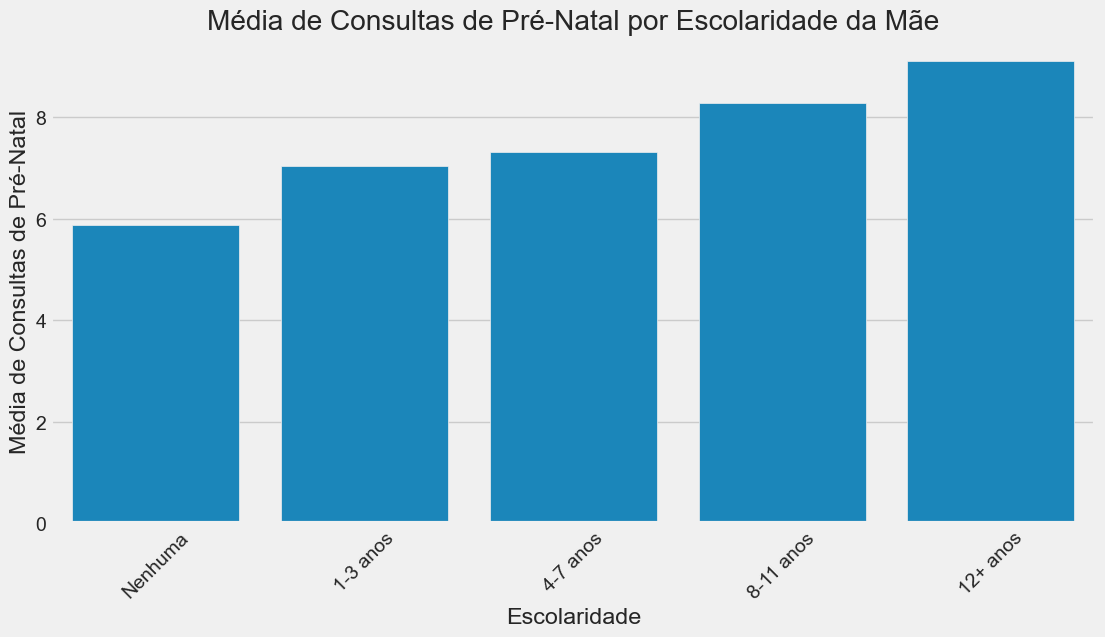

In [92]:
print("""
--- Questão 17: ---
Qual a relação entre a quantidade de consultas de pré-natal, o tempo de estudo, 
o estado civil e ou a raça/cor das mães?
""")

df_q17 = df_final[['CONSPRENAT', 'ESCMAE', 'ESTCIVMAE', 'RACACORMAE']].copy()
escmae_map = {
    1: 'Nenhuma', 
    2: '1-3 anos', 
    3: '4-7 anos', 
    4: '8-11 anos', 
    5: '12+ anos'
}
estcivmae_map = {
    1: 'Solteira',
    2: 'Casada',
    3: 'Viúva',
    4: 'Divorciada',
    5: 'União Estável'
}
racacormae_map = {
    1: 'Branca',
    2: 'Preta',
    3: 'Amarela',
    4: 'Parda',
    5: 'Indígena'
}

df_q17['ESCOLARIDADE'] = df_q17['ESCMAE'].map(escmae_map)
df_q17['ESTADO_CIVIL'] = df_q17['ESTCIVMAE'].map(estcivmae_map)
df_q17['RACA_COR_MAE'] = df_q17['RACACORMAE'].map(racacormae_map)

print("Analisando a média de consultas de pré-natal por diferentes categorias maternas:")
# Relação com Escolaridade
print("\n1 - Média de consultas de pré-natal por Escolaridade da Mãe:")
medi_por_esc = df_q17.groupby('ESCOLARIDADE', observed=True)['CONSPRENAT'].mean().round(2).sort_values(ascending=False)
display(medi_por_esc)

#Relação com Estado Civil
print("\n2 - Média de consultas de pré-natal por Estado Civil da Mãe:")
media_por_estciv = df_q17.groupby('ESTADO_CIVIL')['CONSPRENAT'].mean().round(2).sort_values(ascending=False)
display(media_por_estciv)

#Relação com Raça/Cor
print("\n2 - Média de consultas de pré-natal por Raça/Cor da Mãe:")
media_por_raca = df_q17.groupby('RACA_COR_MAE')['CONSPRENAT'].mean().round(2).sort_values(ascending=False)
display(media_por_raca)

#Conclusão e Visualização da relação mais forte
print("A análise foi feita calculando a média do número de consultas de pré-natal ('CONSPRENAT') para cada categoria das variáveis solicitadas. "
      "Os resultados indicam uma forte relação positiva entre a escolaridade da mãe e o número de consultas de pré-natal: quanto maior o tempo de estudo, "
      "maior a média de consultas realizadas.")

plt.figure(figsize=(12, 6))
ordem_escolaridade = ['Nenhuma', '1-3 anos', '4-7 anos', '8-11 anos', '12+ anos']
sns.barplot(x=medi_por_esc.index, y=medi_por_esc.values, order=ordem_escolaridade)
plt.title('Média de Consultas de Pré-Natal por Escolaridade da Mãe')
plt.xlabel('Escolaridade')
plt.ylabel('Média de Consultas de Pré-Natal')
plt.xticks(rotation=45)
plt.show()